# Training a model with PyTorch

In this notebook, we 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit
%matplotlib inline

## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [12]:
from torchvision import datasets, models, transforms
import os
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(866), # 866 by 1154
        transforms.Scale(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomSizedCrop(866), # 866 by 1154
        transforms.Scale(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100


In [13]:
## Plot an image just to make sure we have something that makes sense.

torch.Size([4, 3, 224, 224])


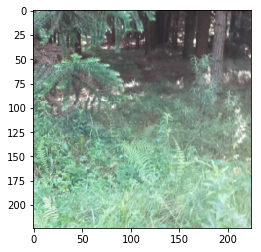

In [14]:
import torchvision.utils
import matplotlib.pyplot as plt

inputs, classes = next(iter(dset_loaders['train']))
to_pil = torchvision.transforms.ToPILImage()
print(inputs.size())
img = to_pil(inputs[0])
plt.imshow(img)

We use the following helper function to help us train a model

In [15]:
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(dset_loaders["val"]):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            #print(x_var.size())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader, istesting):
    if not istesting:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [16]:
# Here we use transfer learning to create a good model based on resnet.
gpu_dtype = torch.cuda.FloatTensor
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, loss_fn, optimizer, num_epochs=5)
check_accuracy(model, dset_loaders["val"], False)

Starting epoch 1 / 5
t = 100, loss = 0.0098
Starting epoch 2 / 5
t = 100, loss = 0.0544
Starting epoch 3 / 5
t = 100, loss = 0.2814
Starting epoch 4 / 5
t = 100, loss = 0.1380
Starting epoch 5 / 5
t = 100, loss = 0.4322
Checking accuracy on validation set
Got 714 / 737 correct (96.88)


We see that this is already an excellent model.